In [1]:
import numpy as np
import pandas as pd
import nltk, json, os, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import vstack

# Initialize NLTK
nltk.download('stopwords')
stemmer = PorterStemmer()

# Define stopwords
cooking_stopwords = ["recipe", "cook", "cooking", "bake", "boil", "grill", "saute", "roast", "simmer", "fry", "stir", "season", "dish", "plate", "meal", "serve"]
standard_stopwords = set(stopwords.words("english"))
stop_words = standard_stopwords.union(cooking_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aesmeral/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print(os.listdir('.'))

['CookingTest.py', 'project.ipynb', 'results.csv', 'train.json', 'sample_submission.csv', '.git', 'README.md', 'test.json', '.ipynb_checkpoints', 'CookingTest.py:Zone.Identifier', 'output.csv']


In [3]:
training_data = pd.read_json('./train.json')
testing_data = pd.read_json('./test.json')

In [4]:
print(training_data.keys())

Index(['id', 'cuisine', 'ingredients'], dtype='object')


In [5]:
print(training_data['cuisine'])

0              greek
1        southern_us
2           filipino
3             indian
4             indian
            ...     
39769          irish
39770        italian
39771          irish
39772        chinese
39773        mexican
Name: cuisine, Length: 39774, dtype: object


In [6]:
print(training_data['ingredients'])

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
39769    [light brown sugar, granulated sugar, butter, ...
39770    [KRAFT Zesty Italian Dressing, purple onion, b...
39771    [eggs, citrus fruit, raisins, sourdough starte...
39772    [boneless chicken skinless thigh, minced garli...
39773    [green chile, jalapeno chilies, onions, ground...
Name: ingredients, Length: 39774, dtype: object


In [7]:
# Efficiently preprocess data
def scrubbed_ingredient(ingredient):
    scrubbed = re.sub(r'[^a-zA-Z ]', '', ingredient).lower()
    scrubbed = re.sub(r'oz|crushed|crumbles|ground|minced|powder|chopped|sliced|boneless|skinless|fresh|frozen|homemade|instance|kraft|large|lean|lowfat|small|smoke|vegan', '', scrubbed).lstrip()
    scrubbed = "_".join([stemmer.stem(word) for word in scrubbed.split() if word not in stop_words])
    return scrubbed

In [8]:
# Efficiently build ingredient vocabulary
ingredients_set = set()
for ingredients_list in training_data['ingredients']:
    scrubbed_ingredients = [scrubbed_ingredient(ingredient) for ingredient in ingredients_list]
    scrubbed_ingredients = [word for word in scrubbed_ingredients if len(word) >= 1]
    ingredients_set.update(scrubbed_ingredients)

sorted_set = sorted(ingredients_set)

In [9]:
# Create a sparse matrix
vectorizer = CountVectorizer(binary=True, vocabulary=sorted_set)
batch_size = 2500  # Adjust the batch size as needed

result = []

for i in range(0, len(training_data), batch_size):
    batch = training_data['ingredients'].iloc[i:i+batch_size]
    scrubbed_ingredients = [" ".join([scrubbed_ingredient(ingredient) for ingredient in row]) for row in batch]
    X = vectorizer.transform(scrubbed_ingredients)
    result.append(X)
    print(i)

# Create a sparse DataFrame
df = pd.DataFrame.sparse.from_spmatrix(vstack(result))
df.columns = sorted_set
df['cuisine'] = training_data['cuisine']
df['id'] = training_data['id']

df.head(100).to_csv('output.csv', index=False)

0
2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500


In [10]:
# Split data
X = df.iloc[:, :-2]
y = df['cuisine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [11]:
# Train and evaluate the model
model = RandomForestClassifier(n_estimators=19, bootstrap=True, random_state=3)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [12]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.700188560653677


In [13]:
results = pd.DataFrame()
results['actual'] = y_test
results['prediction'] = y_predict

print(results.head())

             actual prediction
18708       italian    italian
11518  cajun_creole    mexican
3939        chinese    chinese
27897   southern_us     indian
13952       italian    italian


In [14]:
print(results.shape)
results.to_csv('results.csv', index=False)

(7955, 2)


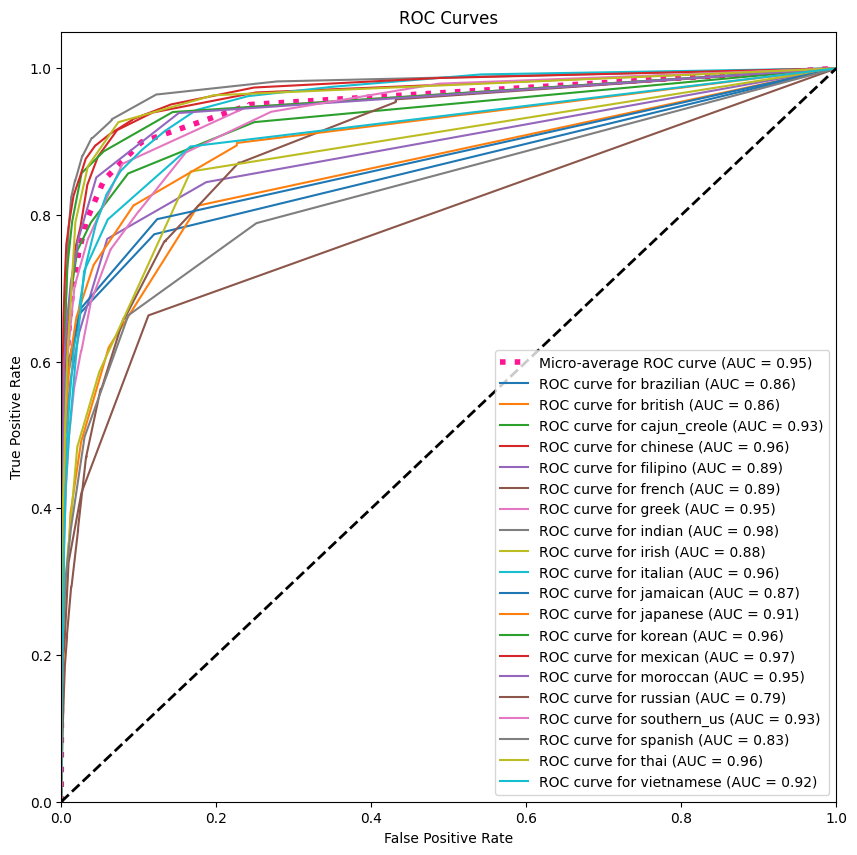

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y_bin = label_binarize(y_test, classes=model.classes_)

# Predict probabilities
y_prob = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()